In [25]:
from tensorflow.keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data,test_targets)= boston_housing.load_data()

In [3]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

#### Normalising the data

In [5]:
mean=train_data.mean(axis=0)
train_data-=mean
std=train_data.std(axis=0)
train_data/=std

In [6]:
test_data-=mean
test_data/=std

In [7]:
from tensorflow.keras import layers 
from tensorflow.keras import models

#### Building a model

In [9]:
def build_model():   
    model=models.Sequential()
    model.add(layers.Dense(64,activation='relu', input_shape=(train_data.shape[1],))) #1 represents the axis here which means the number of columns
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',
             loss='mse',
             metrics=['mae'])
    return model

#### K-fold validation

In [12]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
    epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


#### Saving the validation logs at each fold

In [14]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


#### Building the history of successive mean K-fold validation scores

In [18]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#### Plotting validation scores

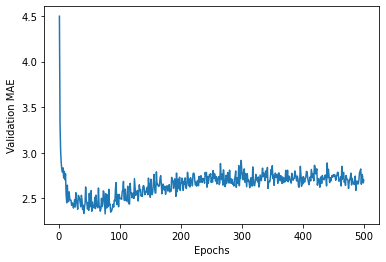

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Plotting validation scores, excluding the first 10 data points

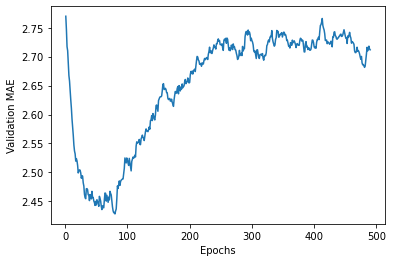

In [22]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Training the final model

In [23]:
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 696us/sample - loss: 17.5514 - mean_absolute_error: 2.6082


In [24]:
test_mae_score

2.608179